In [1]:
#
# Project 2, starter code Part a
#

import math
import tensorflow as tf
import numpy as np
import pylab as plt
import pickle
from tqdm import tqdm

In [2]:
NUM_CLASSES = 10
IMG_SIZE = 32
NUM_CHANNELS = 3
learning_rate = 0.001
epochs = 10
batch_size = 128

seed = 10
np.random.seed(seed)
tf.set_random_seed(seed)

In [3]:
def load_data(file):
    with open(file, 'rb') as fo:
        try:
            samples = pickle.load(fo)
        except UnicodeDecodeError:  #python 3.x
            fo.seek(0)
            samples = pickle.load(fo, encoding='latin1')

    data, labels = samples['data'], samples['labels']

    data = np.array(data, dtype=np.float32)
    labels = np.array(labels, dtype=np.int32)


    labels_ = np.zeros([labels.shape[0], NUM_CLASSES])
    labels_[np.arange(labels.shape[0]), labels-1] = 1

    return data, labels_

In [4]:
def cnn(images, c1_filters, c2_filters):
    images = tf.reshape(images, [-1, IMG_SIZE, IMG_SIZE, NUM_CHANNELS])

    # C1 (50x24x24): Conv layer, 50 filters, window size 9x9, VALID padding, ReLU
    # S1 (50x12x12): Max pooling layer, window size 2x2, stride = 2, VALID padding
    W1 = tf.Variable(tf.truncated_normal([9, 9, NUM_CHANNELS, c1_filters], stddev=1.0/np.sqrt(NUM_CHANNELS*9*9)), name='weights_1')
    b1 = tf.Variable(tf.zeros([c1_filters]), name='biases_1')  
    conv_1 = tf.nn.relu(tf.nn.conv2d(images, W1, [1, 1, 1, 1], padding='VALID') + b1)
    pool_1 = tf.nn.max_pool(conv_1, ksize= [1, 2, 2, 1], strides= [1, 2, 2, 1], padding='VALID', name='pool_1')

    # C2 (60x8x8): Conv layer, 60 filters, window size 5x5, VALID padding, ReLU
    # S2 (60x4x4): Max pooling layer, window size 2x2, stride = 2, VALID padding
    W2 = tf.Variable(tf.truncated_normal([5, 5, c1_filters, c2_filters], stddev=1.0/np.sqrt(c1_filters*5*5)), name='weights_2')
    b2 = tf.Variable(tf.zeros([c2_filters]), name='biases_2')
    conv_2 = tf.nn.relu(tf.nn.conv2d(pool_1, W2, [1, 1, 1, 1], padding='VALID') + b2)
    pool_2 = tf.nn.max_pool(conv_2, ksize= [1, 2, 2, 1], strides= [1, 2, 2, 1], padding='VALID', name='pool_2')

    # Flatten (dim = 60x4x4 = 960)
    dim = pool_2.get_shape()[1].value * pool_2.get_shape()[2].value * pool_2.get_shape()[3].value 
    pool_2_flat = tf.reshape(pool_2, [-1, dim])

    # F3: Fully connected layer of size 300 (960 -> 300)
    W3 = tf.Variable(tf.truncated_normal([dim, 300], stddev=1.0/np.sqrt(dim)), name='weights_3')
    b3 = tf.Variable(tf.zeros([300]), name='biases_3')
    f3_logits = tf.matmul(pool_2_flat, W3) + b3

    # F4: Softmax layer of size 10 (300 -> 10)
    W4 = tf.Variable(tf.truncated_normal([300, NUM_CLASSES], stddev=1.0/np.sqrt(dim)), name='weights_4')
    b4 = tf.Variable(tf.zeros([NUM_CLASSES]), name='biases_4')
    f4_logits = tf.matmul(f3_logits, W4) + b4

    return conv_1, pool_1, conv_2, pool_2, f4_logits

In [5]:
def main(c1_filters, c2_filters):
    trainX, trainY = load_data('./data_batch_1')
    # print(trainX.shape, trainY.shape)

    testX, testY = load_data('./test_batch_trim')
    # print(testX.shape, testY.shape)

    # Scaling the train & test inputs
    trainX = (trainX - np.min(trainX, axis = 0))/np.max(trainX, axis = 0)
    testX = (testX - np.min(testX, axis = 0))/np.max(testX, axis = 0)

    # Create the model
    x = tf.placeholder(tf.float32, [None, NUM_CHANNELS*IMG_SIZE*IMG_SIZE]) # 3x32x32
    y_ = tf.placeholder(tf.float32, [None, NUM_CLASSES])

    c1, s1, c2, s2, logits = cnn(x, c1_filters, c2_filters)

    cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_, logits=logits)
    loss = tf.reduce_mean(cross_entropy)

    train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y_, 1))
    correct_prediction = tf.cast(correct_prediction, tf.float32)
    accuracy = tf.reduce_mean(correct_prediction)

    N = len(trainX)
    idx = np.arange(N)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        # train_loss = []
        # test_acc = []

        for e in tqdm(range(epochs), desc='C1={} | C2={} '.format(c1_filters, c2_filters)):
            np.random.shuffle(idx)
            trainX, trainY = trainX[idx], trainY[idx]
            # temp_train_loss = []

            for start, end in zip(range(0, N, batch_size), range(batch_size, N, batch_size)):
                train_step.run(feed_dict={x: trainX[start:end], y_: trainY[start:end]})
                # temp_train_loss.append(loss.eval(feed_dict={x: trainX[start:end], y_: trainY[start:end]}))

            # _, loss_ = sess.run([train_step, loss], {x: trainX, y_: trainY})

            # trainLoss = np.mean(np.array(temp_train_loss))
            # train_loss.append(trainLoss)
            # testAcc = accuracy.eval(feed_dict={x: testX, y_: testY})
            # test_acc.append(testAcc)

            # if (e % 10 == 0 or e == epochs-1):
                # print('C1: ', c1_filters, ' | C2: ', c2_filters, ' | Epoch: ', e)

        test_acc = accuracy.eval(feed_dict={x: testX, y_: testY})
        print('Test acc: {}\n'.format(test_acc))
        return test_acc

In [6]:
# Main Program
if __name__ == '__main__':
    all_conv_filters = range(10, 311, 50) # 10, 60, 110, 160, 210, 260, 310
    all_test_acc = np.array([])
    
    for c1 in range(len(all_conv_filters)):
        for c2 in range(len(all_conv_filters)):
            all_test_acc = np.append(all_test_acc, main(all_conv_filters[c1], all_conv_filters[c2]))
    
    # all_test_acc[C1:C2]
    reshaped_test_acc = np.reshape(all_test_acc, (len(all_conv_filters), len(all_conv_filters)))

========== C1:  10  | C2:  10  ==========


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.33it/s]


Test acc: 0.1550000011920929

========== C1:  10  | C2:  60  ==========


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.25it/s]


Test acc: 0.17749999463558197

========== C1:  10  | C2:  110  ==========


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.96it/s]


Test acc: 0.17550000548362732

========== C1:  10  | C2:  160  ==========


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.68it/s]


Test acc: 0.1445000022649765

========== C1:  10  | C2:  210  ==========


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.45it/s]


Test acc: 0.18199999630451202

========== C1:  10  | C2:  260  ==========


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.30it/s]


Test acc: 0.15399999916553497

========== C1:  10  | C2:  310  ==========


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.19it/s]


Test acc: 0.1120000034570694

========== C1:  60  | C2:  10  ==========


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.25it/s]


Test acc: 0.2029999941587448

========== C1:  60  | C2:  60  ==========


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:09<00:00,  1.09it/s]


Test acc: 0.19099999964237213

========== C1:  60  | C2:  110  ==========


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.12s/it]


Test acc: 0.1940000057220459

========== C1:  60  | C2:  160  ==========


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.24s/it]


Test acc: 0.18449999392032623

========== C1:  60  | C2:  210  ==========


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.40s/it]


Test acc: 0.17149999737739563

========== C1:  60  | C2:  260  ==========


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:15<00:00,  1.58s/it]


Test acc: 0.17149999737739563

========== C1:  60  | C2:  310  ==========


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:16<00:00,  1.69s/it]


Test acc: 0.17499999701976776

========== C1:  110  | C2:  10  ==========


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.28s/it]


Test acc: 0.2370000034570694

========== C1:  110  | C2:  60  ==========


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.43s/it]


Test acc: 0.21050000190734863

========== C1:  110  | C2:  110  ==========


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:16<00:00,  1.65s/it]


Test acc: 0.2004999965429306

========== C1:  110  | C2:  160  ==========


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:18<00:00,  1.83s/it]


Test acc: 0.21400000154972076

========== C1:  110  | C2:  210  ==========


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:20<00:00,  2.06s/it]


Test acc: 0.1914999932050705

========== C1:  110  | C2:  260  ==========


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:22<00:00,  2.26s/it]


Test acc: 0.1965000033378601

========== C1:  110  | C2:  310  ==========


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:24<00:00,  2.48s/it]


Test acc: 0.1589999943971634

========== C1:  160  | C2:  10  ==========


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:17<00:00,  1.77s/it]


Test acc: 0.1889999955892563

========== C1:  160  | C2:  60  ==========


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.95s/it]


Test acc: 0.22550000250339508

========== C1:  160  | C2:  110  ==========


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:22<00:00,  2.26s/it]


Test acc: 0.22300000488758087

========== C1:  160  | C2:  160  ==========


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:24<00:00,  2.47s/it]


Test acc: 0.19949999451637268

========== C1:  160  | C2:  210  ==========


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:27<00:00,  2.74s/it]


Test acc: 0.20499999821186066

========== C1:  160  | C2:  260  ==========


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:30<00:00,  3.04s/it]


Test acc: 0.20350000262260437

========== C1:  160  | C2:  310  ==========


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:32<00:00,  3.25s/it]


Test acc: 0.19200000166893005

========== C1:  210  | C2:  10  ==========


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:22<00:00,  2.22s/it]


Test acc: 0.23350000381469727

========== C1:  210  | C2:  60  ==========


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:24<00:00,  2.44s/it]


Test acc: 0.20600000023841858

========== C1:  210  | C2:  110  ==========


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:27<00:00,  2.78s/it]


Test acc: 0.20200000703334808

========== C1:  210  | C2:  160  ==========


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:31<00:00,  3.12s/it]


Test acc: 0.210999995470047

========== C1:  210  | C2:  210  ==========


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:33<00:00,  3.37s/it]


Test acc: 0.19550000131130219

========== C1:  210  | C2:  260  ==========


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:36<00:00,  3.68s/it]


Test acc: 0.19099999964237213

========== C1:  210  | C2:  310  ==========


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:41<00:00,  4.13s/it]


Test acc: 0.19200000166893005

========== C1:  260  | C2:  10  ==========


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:28<00:00,  2.81s/it]


Test acc: 0.27149999141693115

========== C1:  260  | C2:  60  ==========


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:30<00:00,  3.04s/it]


Test acc: 0.24500000476837158

========== C1:  260  | C2:  110  ==========


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:34<00:00,  3.45s/it]


Test acc: 0.2240000069141388

========== C1:  260  | C2:  160  ==========


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:37<00:00,  3.79s/it]


Test acc: 0.20800000429153442

========== C1:  260  | C2:  210  ==========


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:41<00:00,  4.15s/it]


Test acc: 0.210999995470047

========== C1:  260  | C2:  260  ==========


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:45<00:00,  4.59s/it]


Test acc: 0.20749999582767487

========== C1:  260  | C2:  310  ==========


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:49<00:00,  4.99s/it]


Test acc: 0.20499999821186066

========== C1:  310  | C2:  10  ==========


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:31<00:00,  3.16s/it]


Test acc: 0.23350000381469727

========== C1:  310  | C2:  60  ==========


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:35<00:00,  3.53s/it]


Test acc: 0.2214999943971634

========== C1:  310  | C2:  110  ==========


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:40<00:00,  4.04s/it]


Test acc: 0.22200000286102295

========== C1:  310  | C2:  160  ==========


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:43<00:00,  4.38s/it]


Test acc: 0.2134999930858612

========== C1:  310  | C2:  210  ==========


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:47<00:00,  4.79s/it]


Test acc: 0.2134999930858612

========== C1:  310  | C2:  260  ==========


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:52<00:00,  5.21s/it]


Test acc: 0.1965000033378601

========== C1:  310  | C2:  310  ==========


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:57<00:00,  5.79s/it]


Test acc: 0.22300000488758087



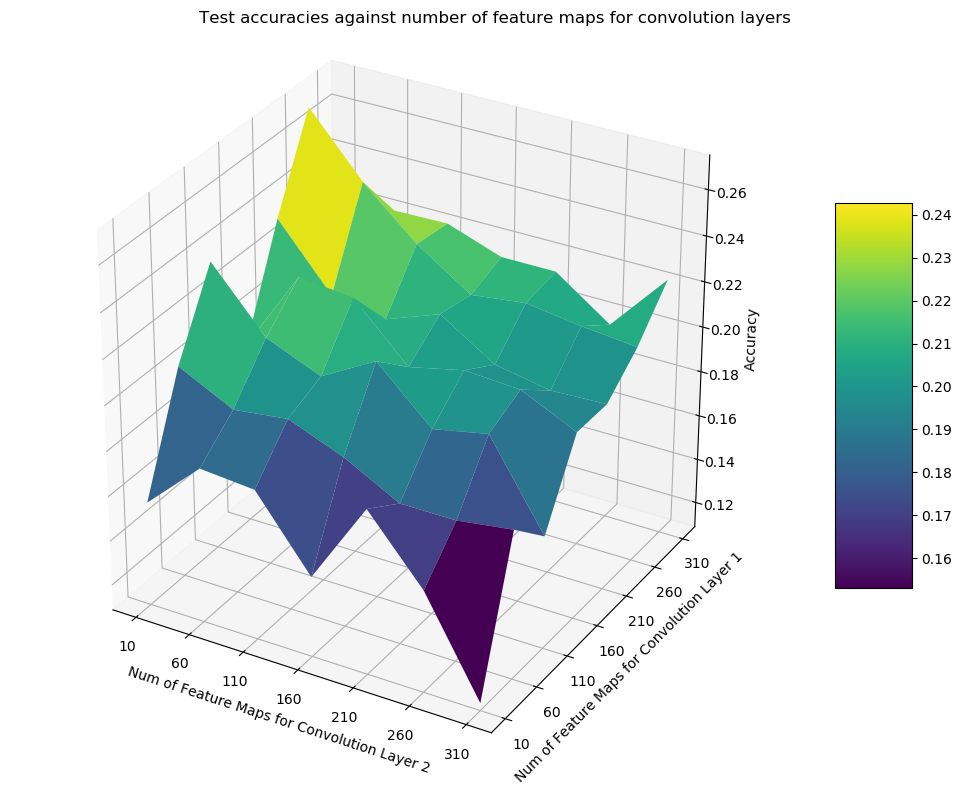

In [7]:
    # Plot all test accuracies
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure(figsize=(10, 8), dpi=100)
    ax = fig.gca(projection='3d')

    plt.suptitle('Test accuracies against number of feature maps for convolution layers')
    
    # [C1:C2] == [X:Y] == indexing='ij'
    X, Y = np.meshgrid(all_conv_filters, all_conv_filters, indexing='ij')
    
    # Swap to [Y:X] for a better view (As graph increases towards the viewer)
    surf = ax.plot_surface(Y, X, reshaped_test_acc, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
    ax.set_xlabel('Num of Feature Maps for Convolution Layer 2')
    ax.set_ylabel('Num of Feature Maps for Convolution Layer 1')
    ax.set_zlabel('Accuracy')
    
    plt.xticks(all_conv_filters)
    plt.yticks(all_conv_filters)
    plt.tight_layout()
    plt.colorbar(surf, shrink=0.5, aspect=5)
    plt.savefig('./2.Attempt3_TestAcc_NumOfFM.png')

    plt.show()